In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import random
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, accuracy_score
import os
from sklearn.utils import shuffle
import time
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

def cotan(angle):
    return -np.tan(angle + np.pi/2)

# Function to convert ellipse to rectangular box
def ellipse_to_rectangle(major_axis, minor_axis, angle, center_x, center_y):
    t1 = np.arctan(-minor_axis * np.tan(angle) / major_axis)
    t2 = np.arctan(minor_axis * cotan(angle) / major_axis)
    xoff = abs(major_axis * np.cos(t1) * np.cos(angle) - minor_axis * np.sin(t1) * np.sin(angle))
    yoff = abs(minor_axis * np.sin(t2) * np.cos(angle) - major_axis * np.cos(t2) * np.sin(angle))
    x1 = center_x - xoff
    y1 = center_y - yoff
    x2 = center_x + xoff
    y2 = center_y + yoff
    return [x1, y1, x2, y2]

def get_image(image_path, scale=6):
    image = cv2.imread(image_path)
    new_height = int(image.shape[0] / scale)
    new_width = int(image.shape[1] / scale)
    return cv2.resize(image, (new_width, new_height))

# Parse FDDB dataset files and convert ellipse annotations to rectangles.
# Split into training and testing datasets.
def parse_fddb_dataset(folder_path, num_training=8):
    training_data = []
    testing_data = []

    for i in range(1, 11):
        file_path = os.path.join(folder_path, f'FDDB-fold-{i:02}-ellipseList.txt')
        with open(file_path, 'r') as file:
            lines = file.readlines()

        current_image = None
        face_count = 0
        get_face_count = False
        for line in lines:
            if get_face_count:
                face_count = int(line.strip())
                get_face_count = False
            elif face_count == 0:
                if current_image is not None:
                    # Process previous image
                    if i <= num_training:
                        training_data.append((current_image, faces))
                    else:
                        testing_data.append((current_image, faces))

                current_image = os.path.join('/content/drive/MyDrive/Colab Notebooks/CV_dataset/originalPics/', line.strip() + '.jpg')
                faces = []
                get_face_count = True
            else:
                parts = [float(part) for part in line.split()]
                rect = ellipse_to_rectangle(*parts[:5])
                faces.append(rect)
                face_count -= 1

        # Process the last image
        if current_image is not None:
            if i <= num_training:
                training_data.append((current_image, faces))
            else:
                testing_data.append((current_image, faces))

    return training_data, testing_data

def calculate_iou(boxA, boxB):
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection
    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both bounding boxes
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute the intersection over union
    iou = intersection_area / float(boxAArea + boxBArea - intersection_area)
    return iou

def sliding_window(image, step_size, window_size):
    for x in range(0, image.shape[1], step_size):
        for y in range(0, image.shape[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def generate_samples_using_sliding_window(image, faces, window_size, step_size, iou_threshold, scale=6):
    positive_samples = []
    negative_samples = []

    for (x, y, window) in sliding_window(image, step_size, window_size):
        # if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
        #     continue

        scaled_box = [x * scale, y * scale, (x + window_size[0]) * scale, (y + window_size[1]) * scale]
        # print(scaled_box, faces)
        ious = [calculate_iou(scaled_box, face) for face in faces]
        max_iou = max(ious) if ious else 0
        # print(max_iou)

        current_box = [x, y, x + window_size[0], y + window_size[1]]
        if max_iou >= iou_threshold:
            positive_samples.append(current_box)
        else:
            negative_samples.append(current_box)

    return positive_samples, negative_samples

# Function to extract features in an image
def extract_features(image, box):
    # don't include this image if a dimension = 0
    # if int(box[3]) == int(box[1]) or int(box[2]) == int(box[0]):
    #     return [-1]
    cropped_image = image[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
    # feature_vector = cropped_image.flatten()
    # feature_vector = cv2.resize(cropped_image, (16, 16)).flatten()
    feature_vector = cv2.resize(cropped_image, (32, 32))
    return feature_vector

def extract_dataset_features(data):
    # Prepare data for classifier
    # X, y = [], []
    X_pos, X_neg, y_pos, y_neg = [], [], [], []
    count_pos = 0
    count_neg = 0
    scale = 3
    for image_path, boxes in data:
        image = get_image(image_path, scale)
        pos_samples, neg_samples = generate_samples_using_sliding_window(image, boxes, window_size=(32, 32), step_size=4, iou_threshold=0.5, scale=scale)
        # print(neg_samples)
        for box in pos_samples:
            feature = extract_features(image, box)
            # if feature[0] == -1:
            #     continue
            count_pos += 1
            X_pos.append(feature)
            y_pos.append(1)  # Label for face

        for neg_box in neg_samples:
            feature = extract_features(image, neg_box)
            # if feature[0] == -1:
            #     continue
            count_neg += 1
            X_neg.append(feature)
            y_neg.append(0)  # Label for non-face

    # standardize the dataset
    if count_pos < count_neg:
        data_size = count_pos
        random_rows = random.sample(range(count_neg), data_size)
        X_neg = [X_neg[i] for i in random_rows]
        # y_neg = [y_neg[i] for i in random_rows]
        y_neg = [0] * data_size
    else:
        data_size = count_neg
        random_rows = random.sample(range(count_pos), data_size)
        X_pos = [X_pos[i] for i in random_rows]
        # y_pos = [y_pos[i] for i in random_rows]
        y_pos = [1] * data_size

    y_pos_np = np.array(data_size * [[0,1]])
    y_neg_np = np.array(data_size * [[1,0]])

    X = np.array(X_pos + X_neg)
    # y = np.array(y_pos_np + y_neg_np)
    y = np.concatenate((y_pos_np, y_neg_np))

    X, y = shuffle(X, y)

    return X, y

training_data, testing_data = parse_fddb_dataset('/content/drive/MyDrive/Colab Notebooks/CV_dataset/FDDB-folds')

X_train, y_train = extract_dataset_features(training_data)
X_test, y_test = extract_dataset_features(testing_data)

In [3]:
# define alexnet cnn model
def define_alexnet_model(learning_rate):
    model = keras.Sequential()
    model.add(layers.Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(11,11), strides=(4,4), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))  # compile model
    opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # blue = training data; orange = validation data
	# plot validation loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')

Epoch 1/18
883/883 [==============================] - 25s 13ms/step - loss: 0.3860 - accuracy: 0.8350
Epoch 2/18
883/883 [==============================] - 11s 13ms/step - loss: 0.2434 - accuracy: 0.9069
Epoch 3/18
883/883 [==============================] - 12s 13ms/step - loss: 0.2094 - accuracy: 0.9196
Epoch 4/18
883/883 [==============================] - 12s 13ms/step - loss: 0.1800 - accuracy: 0.9311
Epoch 5/18
883/883 [==============================] - 11s 13ms/step - loss: 0.1565 - accuracy: 0.9397
Epoch 6/18
883/883 [==============================] - 12s 13ms/step - loss: 0.1394 - accuracy: 0.9469
Epoch 7/18
883/883 [==============================] - 12s 13ms/step - loss: 0.1207 - accuracy: 0.9544
Epoch 8/18
883/883 [==============================] - 11s 13ms/step - loss: 0.1106 - accuracy: 0.9584
Epoch 9/18
883/883 [==============================] - 12s 13ms/step - loss: 0.0934 - accuracy: 0.9647
Epoch 10/18
883/883 [==============================] - 12s 13ms/step - loss: 0.081

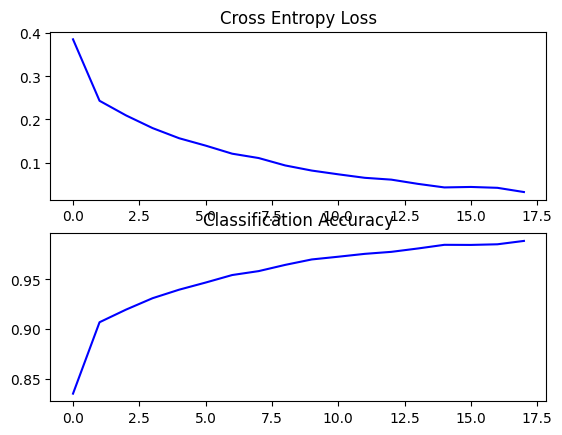

In [5]:
# Train an CNN classifier on the provided features and labels.
def train_cnn_classifier(X_train, y_train):
    classifier = define_alexnet_model(0.001)
    history = classifier.fit(X_train, y_train, epochs=18, batch_size=64, verbose=1)
    summarize_diagnostics(history)
    # classifier = SVC(gamma='auto', verbose=True)
    # classifier.fit(X_train, y_train)
    return classifier

start_time = time.time()
classifier = train_cnn_classifier(X_train, y_train)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds.")

# Calculate accuracy
# predictions = classifier.predict(X_test)
# accuracy = accuracy_score(y_test, predictions)
_, accuracy = classifier.evaluate(X_test, y_test, verbose=1)
print("Accuracy:", accuracy)

464/464 [==============================] - 4s 9ms/step


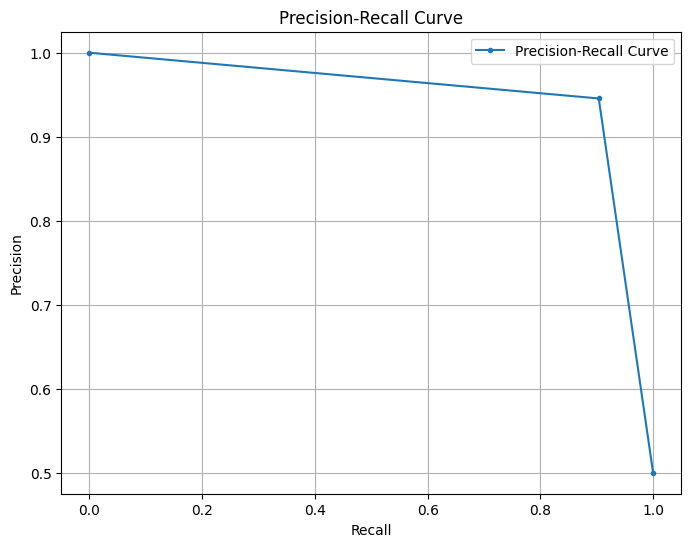

In [7]:
predictions = classifier.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test.argmax(axis=1), predictions.argmax(axis=1))
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/18
882/882 [==============================] - 41s 45ms/step - loss: 0.3938 - accuracy: 0.8316
Epoch 2/18
882/882 [==============================] - 42s 47ms/step - loss: 0.2760 - accuracy: 0.8927
Epoch 3/18
882/882 [==============================] - 40s 45ms/step - loss: 0.2451 - accuracy: 0.9044
Epoch 4/18
882/882 [==============================] - 41s 46ms/step - loss: 0.2208 - accuracy: 0.9147
Epoch 5/18
882/882 [==============================] - 40s 45ms/step - loss: 0.2101 - accuracy: 0.9188
Epoch 6/18
882/882 [==============================] - 40s 46ms/step - loss: 0.1990 - accuracy: 0.9230
Epoch 7/18
882/882 [==============================] - 41s 46ms/step - loss: 0.1907 - accuracy: 0.9259
Epoch 8/18
882/882 [==============================] - 42s 48ms/step - loss: 0.1808 - accuracy: 0.9310
Epoch 9/18
882/882 [==============================] - 42s 47ms/step - loss: 0.1766 - accuracy: 0.9329
Epoch 10/18
882/882 [==============================] - 39s 45ms/step - loss: 0.172

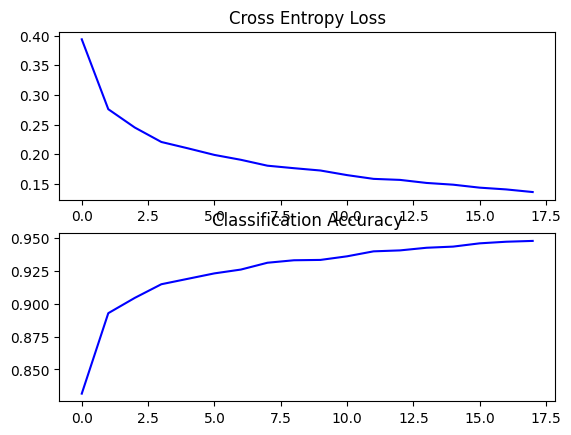

In [9]:
from keras.preprocessing.image import ImageDataGenerator

# train the cnn classifier with data augmentation
def train_cnn_classifier_data_augmentation(X_train, y_train):
    # define model
    model = define_alexnet_model(0.001)
    # create data generator
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    # prepare iterator
    it_train = datagen.flow(X_train, y_train, batch_size=64)
    # fit model
    steps = int(X_train.shape[0] / 64)
    history = model.fit(it_train, epochs=18, steps_per_epoch=steps, verbose=1)
    # plot model diagnostics
    summarize_diagnostics(history)
    # evaluate model
    return model

start_time = time.time()
classifier_data_aug = train_cnn_classifier_data_augmentation(X_train, y_train)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds.")

# Calculate accuracy
# predictions = classifier.predict(X_test)
# accuracy = accuracy_score(y_test, predictions)
_, accuracy = classifier_data_aug.evaluate(X_test, y_test, verbose=1)
print("Accuracy:", accuracy)

464/464 [==============================] - 2s 5ms/step


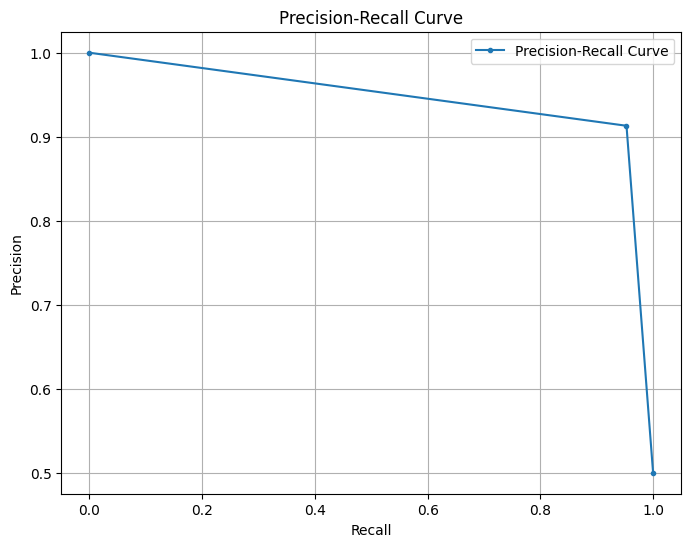

In [13]:
predictions = classifier_data_aug.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test.argmax(axis=1), predictions.argmax(axis=1))
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from tensorflow.keras import regularizers

# define cnn alexnet model with both weight regularizatio and batch normaliztion
def define_model_weight_regularization_batch_normalization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(11,11), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

Epoch 1/18
883/883 [==============================] - 21s 16ms/step - loss: 48.7008 - accuracy: 0.8684
Epoch 2/18
883/883 [==============================] - 14s 16ms/step - loss: 34.2034 - accuracy: 0.9164
Epoch 3/18
883/883 [==============================] - 14s 16ms/step - loss: 24.0675 - accuracy: 0.9282
Epoch 4/18
883/883 [==============================] - 14s 16ms/step - loss: 16.9526 - accuracy: 0.9373
Epoch 5/18
883/883 [==============================] - 14s 16ms/step - loss: 11.9588 - accuracy: 0.9445
Epoch 6/18
883/883 [==============================] - 14s 16ms/step - loss: 8.4654 - accuracy: 0.9450
Epoch 7/18
883/883 [==============================] - 15s 17ms/step - loss: 6.0063 - accuracy: 0.9503
Epoch 8/18
883/883 [==============================] - 14s 16ms/step - loss: 4.2820 - accuracy: 0.9533
Epoch 9/18
883/883 [==============================] - 14s 16ms/step - loss: 3.0722 - accuracy: 0.9554
Epoch 10/18
883/883 [==============================] - 14s 16ms/step - loss: 

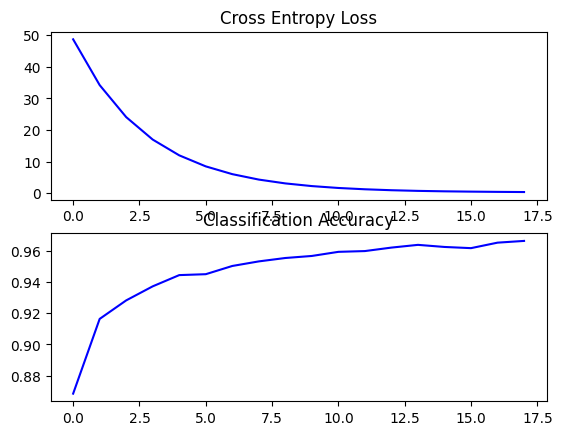

In [11]:
# Train an CNN classifier on the provided features and labels.
def train_cnn_weight_batch_classifier(X_train, y_train):
    classifier = define_model_weight_regularization_batch_normalization(0.001)
    history = classifier.fit(X_train, y_train, epochs=18, batch_size=64, verbose=1)
    summarize_diagnostics(history)
    # classifier = SVC(gamma='auto', verbose=True)
    # classifier.fit(X_train, y_train)
    return classifier

start_time = time.time()
classifier_weight_batch = train_cnn_weight_batch_classifier(X_train, y_train)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds.")

# Calculate accuracy
# predictions = classifier.predict(X_test)
# accuracy = accuracy_score(y_test, predictions)
_, accuracy = classifier_weight_batch.evaluate(X_test, y_test, verbose=1)
print("Accuracy:", accuracy)

464/464 [==============================] - 2s 3ms/step


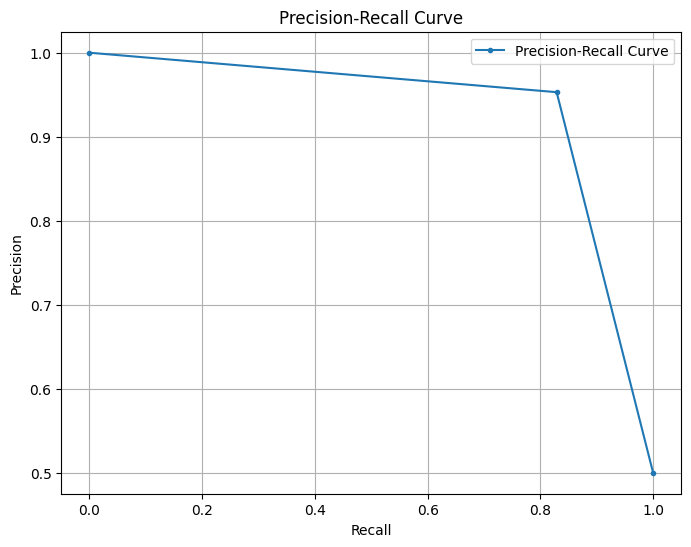

In [14]:
predictions = classifier_weight_batch.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test.argmax(axis=1), predictions.argmax(axis=1))
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()